In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing

In [4]:
df = pd.read_csv('uber.csv')

In [6]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [7]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [8]:
df = df.drop(['Unnamed: 0', 'key'], axis=1)

In [9]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [10]:
df.dropna(axis=0,inplace=True)

In [11]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [12]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce') 

In [13]:
df= df.assign(
    second = df.pickup_datetime.dt.second,
    minute = df.pickup_datetime.dt.minute,
    hour = df.pickup_datetime.dt.hour,
    day= df.pickup_datetime.dt.day,
    month = df.pickup_datetime.dt.month,
    year = df.pickup_datetime.dt.year,
    dayofweek = df.pickup_datetime.dt.dayofweek
)
df = df.drop('pickup_datetime',axis=1)

In [15]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,second,minute,hour,day,month,year,dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,6,52,19,7,5,2015,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,56,4,20,17,7,2009,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,0,45,21,24,8,2009,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,21,22,8,26,6,2009,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,0,47,17,28,8,2014,3


In [16]:
incorrect_coordinates = df.loc[
    (df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
    (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
    (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
    (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
]

df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [17]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    long1, lati1, long2, lati2 = map(np.radians, [longitude1, latitude1, longitude2, latitude2])
    dist_long = long2 - long1
    dist_lati = lati2 - lati1
    a = np.sin(dist_lati/2)**2 + np.cos(lati1) * np.cos(lati2) * np.sin(dist_long/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) * 6371  
    return c

In [18]:
df['Distance'] = distance_transform(
    df['pickup_longitude'],
    df['pickup_latitude'],
    df['dropoff_longitude'],
    df['dropoff_latitude']
)

Text(0, 0.5, 'fare_amount')

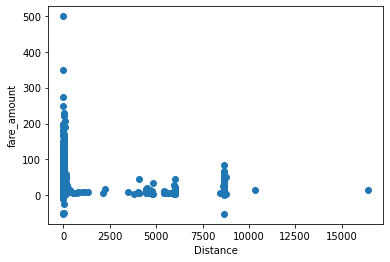

In [20]:
plt.scatter(df['Distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

<AxesSubplot:>

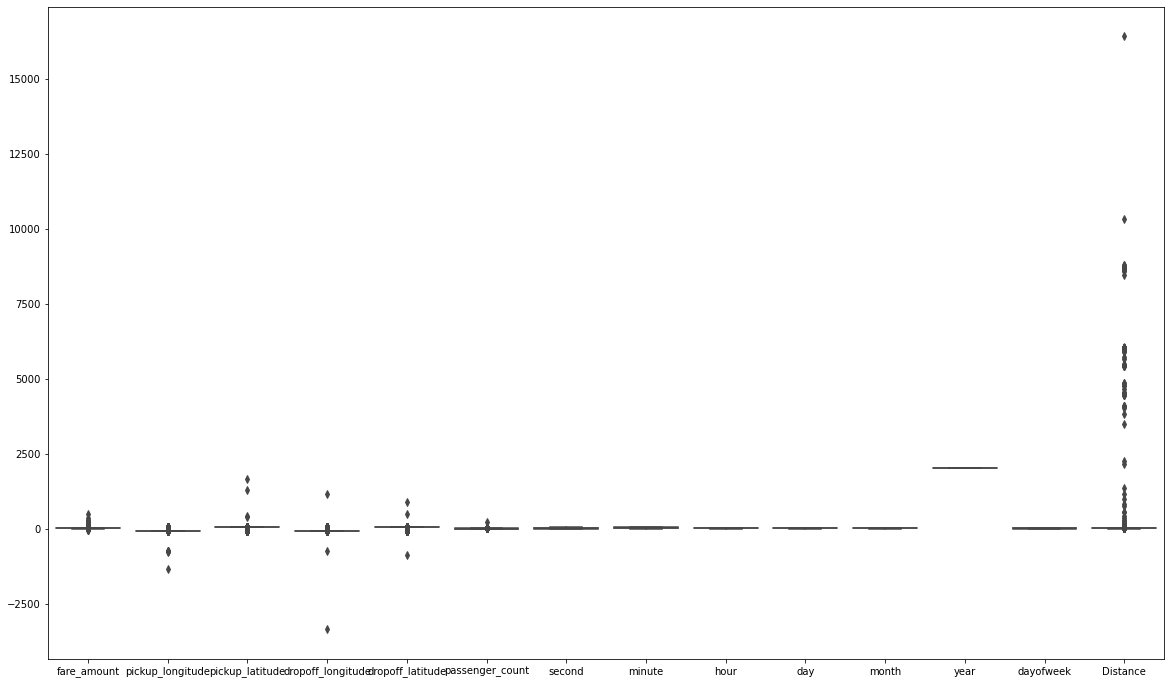

In [21]:
plt.figure(figsize=(20,12))
sns.boxplot(data = df)

In [22]:
df.drop(df[df['Distance'] >= 60].index, inplace = True)
df.drop(df[df['fare_amount'] <= 0].index, inplace = True)

df.drop(df[(df['fare_amount']>100) & (df['Distance']<1)].index, inplace = True )
df.drop(df[(df['fare_amount']<100) & (df['Distance']>100)].index, inplace = True )

Text(0, 0.5, 'fare_amount')

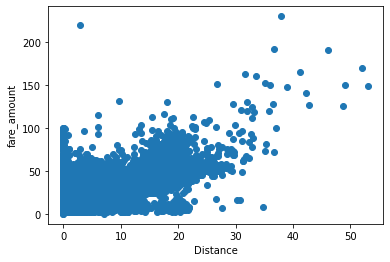

In [23]:
plt.scatter(df['Distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

In [24]:
corr = df.corr()

corr.style.background_gradient(cmap='BuGn')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,second,minute,hour,day,month,year,dayofweek,Distance
fare_amount,1.000000,0.005885,-0.006253,0.005501,-0.006142,0.011693,-0.000995,-0.007795,-0.020692,0.001059,0.023759,0.121195,0.006181,0.857729
pickup_longitude,0.005885,1.000000,-0.973204,0.999992,-0.981941,-0.000649,-0.014677,0.002796,0.001547,0.005300,-0.002667,0.005907,0.003006,-0.117044
pickup_latitude,-0.006253,-0.973204,1.000000,-0.973206,0.991076,-0.001190,0.016809,-0.002295,-0.001823,-0.008901,0.004098,-0.008466,-0.004787,0.110843
dropoff_longitude,0.005501,0.999992,-0.973206,1.000000,-0.981942,-0.000650,-0.014638,0.002803,0.001316,0.005307,-0.002656,0.005878,0.003082,-0.117282
dropoff_latitude,-0.006142,-0.981941,0.991076,-0.981942,1.000000,-0.001035,0.017202,-0.002593,-0.001460,-0.008900,0.004143,-0.008553,-0.004648,0.109486
passenger_count,0.011693,-0.000649,-0.001190,-0.000650,-0.001035,1.000000,-0.202987,0.000733,0.013226,0.003146,0.009921,0.004841,0.033360,0.007784
second,-0.000995,-0.014677,0.016809,-0.014638,0.017202,-0.202987,1.000000,0.001893,-0.013419,-0.002100,-0.049734,0.083106,-0.000113,-0.000350
minute,-0.007795,0.002796,-0.002295,0.002803,-0.002593,0.000733,0.001893,1.000000,0.001352,-0.001255,-0.001606,-0.002687,-0.002405,-0.007998
hour,-0.020692,0.001547,-0.001823,0.001316,-0.001460,0.013226,-0.013419,0.001352,1.000000,0.004849,-0.003989,0.002171,-0.086995,-0.031855
day,0.001059,0.005300,-0.008901,0.005307,-0.008900,0.003146,-0.002100,-0.001255,0.004849,1.000000,-0.017330,-0.012055,0.005559,0.000008


In [25]:
X = df['Distance'].values.reshape(-1, 1)        #Independent Variable
y = df['fare_amount'].values.reshape(-1, 1)     #Dependent Variable

In [26]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
y_std = std.fit_transform(y)
print(y_std)

x_std = std.fit_transform(X)
print(x_std)

[[-0.39820843]
 [-0.37738556]
 [ 0.1640092 ]
 ...
 [ 2.03806797]
 [ 0.3305922 ]
 [ 0.28894645]]
[[-0.43819769]
 [-0.22258873]
 [ 0.49552213]
 ...
 [ 2.67145829]
 [ 0.07874908]
 [ 0.60173174]]


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=0)

In [28]:
from sklearn.linear_model import LinearRegression
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)

print("Training set score: {:.2f}".format(l_reg.score(X_train, y_train)))
print("Test set score: {:.7f}".format(l_reg.score(X_test, y_test)))

Training set score: 0.74
Test set score: 0.7340468


In [29]:
y_pred = l_reg.predict(X_test)

result = pd.DataFrame()
result[['Actual']] = y_test
result[['Predicted']] = y_pred

result.sample(10)

,Actual,Predicted
10976,3.193738,3.072025
20605,-0.377386,-0.264723
19271,-0.335740,0.057154
38193,-0.502323,-0.233560
34637,-0.502323,-0.564864
25553,-0.242037,-0.125310
21190,-0.710552,-0.643854
33555,2.707523,1.462142
1282,-0.137922,-0.209317
15816,0.080718,0.615002


In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared (R²):', np.sqrt(metrics.r2_score(y_test, y_pred)))

Mean Absolute Error: 0.2662129875793894
Mean Absolute % Error: 1.983074763340742
Mean Squared Error: 0.27052435107785416
Root Mean Squared Error: 0.5201195546005304
R Squared (R²): 0.8567653080822022


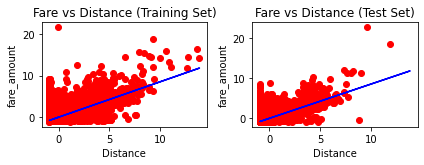

In [31]:
plt.subplot(2, 2, 1)
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, l_reg.predict(X_train), color ="blue")
plt.title("Fare vs Distance (Training Set)")
plt.ylabel("fare_amount")
plt.xlabel("Distance")

plt.subplot(2, 2, 2)
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_train, l_reg.predict(X_train), color ="blue")
plt.ylabel("fare_amount")
plt.xlabel("Distance")
plt.title("Fare vs Distance (Test Set)")

plt.tight_layout()
plt.show()

In [32]:
cols = ['Model', 'RMSE', 'R-Squared']

# create a empty dataframe of the colums
# columns: specifies the columns to be selected
result_tabulation = pd.DataFrame(columns = cols)

# compile the required information
linreg_metrics = pd.DataFrame([[
     "Linear Regresion model",
     np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
     np.sqrt(metrics.r2_score(y_test, y_pred))
]], columns = cols)

result_tabulation = pd.concat([result_tabulation, linreg_metrics], ignore_index=True)

result_tabulation

,Model,RMSE,R-Squared
0,Linear Regresion model,0.52012,0.856765


In [33]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)

# fit the regressor with training dataset
rf_reg.fit(X_train, y_train)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23652\2264728154.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


RandomForestRegressor(random_state=10)

In [34]:
y_pred_RF = rf_reg.predict(X_test)

result = pd.DataFrame()
result[['Actual']] = y_test
result['Predicted'] = y_pred_RF

result.sample(10)

,Actual,Predicted
12693,-0.294094,-0.273375
21947,-0.419031,-0.379364
37771,-0.460677,-0.609456
35235,-0.450266,-0.422779
21846,-0.710552,-0.674736
23888,-0.210803,-0.110540
30130,-0.169157,-0.231802
38202,-0.085865,-0.242141
19984,0.642935,-0.007571
15823,0.122363,0.643560


In [35]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_RF))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_RF))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_RF))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))
print('R Squared (R²):', np.sqrt(metrics.r2_score(y_test, y_pred_RF)))

Mean Absolute Error: 0.3077087698385678
Mean Absolute % Error: 2.161623761570947
Mean Squared Error: 0.33297733033643484
Root Mean Squared Error: 0.5770418791876677
R Squared (R²): 0.8201518783882692


In [37]:
# compile the required information
random_forest_metrics = pd.DataFrame([[
     "Random Forest Regressor model",
     np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)),
     np.sqrt(metrics.r2_score(y_test, y_pred_RF))
]], columns = cols)

result_tabulation = pd.concat([result_tabulation, random_forest_metrics], ignore_index=True)

result_tabulation

,Model,RMSE,R-Squared
0,Linear Regresion model,0.52012,0.856765
1,Random Forest Regressor model,0.577042,0.820152
